# Time Series Forecasting Project - Dự Báo Giá Chứng Khoán

🚀 Ứng dụng các kỹ thuật từ ARIMA (SARIMAX), Auto ARIMA, đến Machine Learning (Random Forest, XGBoost) và Deep Learning (LSTM) trong dự báo giá chứng khoán, dự án này mang lại cái nhìn toàn diện về dự báo chuỗi thời gian và so sánh các model được áp dụng.

🚀 Mục tiêu là khám phá, tối ưu độ chính xác và mở rộng khả năng ứng dụng trong các bối cảnh thực tế đó dự báo giá chứng khoán của Google.

-----
## Outline


  - [1. Tạo ARIMA (SARIMA) model để dự báo](#21-tạo-arima-sarima-để-dự-báo)
  - [2. Dùng Auto ARIMA model](#22-dùng-auto-arima)
  - [3. Dùng Random Forest, XGBoost model](#23-dùng-random-forest-xgboost-model)
  - [4. Sử dụng Deeplearning (LSTM)](#24-sử-dụng-deeplearning-lstm)
  - [5. Kết luận](#24-sử-dụng-deeplearning-lstm)


--------
## Giới thiệu về Dataset

Dataset này chứa các thông tin giá giao dịch chứng khoán, bao gồm các feature:

- Date: Ngày giao dịch.
- Open: Giá mở cửa của cổ phiếu trong ngày.
- High: Giá cao nhất trong ngày (Feature cần dự báo).
- Low: Giá thấp nhất trong ngày.
- Close: Giá đóng cửa, thường dùng để đánh giá xu hướng thị trường.
- Volume: Khối lượng giao dịch, phản ánh mức độ hoạt động của cổ phiếu.

-----------
## Time Series Forecasting Analysis

### Tạo ARIMA (SARIMA) model để dự báo

In [15]:
# Import libaries
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm # Thống kê chuỗi thời gian
from statsmodels.tsa.stattools import adfuller, acf, pacf # Kiểm định các thống kê: dừng, tính tương quan, tương quan từng phần
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Thống kê tương quan

In [16]:
# Load the data
train_data = pd.read_csv(r"C:\Users\Dell03.LAPTOP-PTNNLMOI\Desktop\SANG\Machine Learning\Final_K298-20241027T013257Z-001\GK_ML_K298_Nguyen_Dinh_Sang\Google_Stock_Price_Train.csv")
test_data = pd.read_csv(r"C:\Users\Dell03.LAPTOP-PTNNLMOI\Desktop\SANG\Machine Learning\Final_K298-20241027T013257Z-001\GK_ML_K298_Nguyen_Dinh_Sang\Google_Stock_Price_Test.csv")

In [17]:
# Hiển thị tập train
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [18]:
# Hiển thị tập test
test_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


Các tập dữ liệu Train và Test đều bao gồm các cột:

- Date: Ngày giao dịch.
- Open: Giá mở cửa.
- High: Giá cao nhất trong ngày (biến mục tiêu cần dự báo).
- Low: Giá thấp nhất trong ngày.
- Close: Giá đóng cửa.
- Volume: Khối lượng giao dịch.

In [19]:
# Mô tả tập train
train_data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [20]:
# Mô tả tập test
test_data.describe()

,Open,High,Low,Close
count,20.000000,20.000000,20.000000,20.000000
mean,807.526000,811.926500,801.949500,807.904500
std,15.125428,14.381198,13.278607,13.210088
min,778.810000,789.630000,775.800000,786.140000
25%,802.965000,806.735000,797.427500,802.282500
50%,806.995000,808.640000,801.530000,806.110000
75%,809.560000,817.097500,804.477500,810.760000
max,837.810000,841.950000,827.010000,835.670000


In [21]:
# Chuyển đổi loại feature Date
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

In [22]:
# Đặt Ngày làm chỉ mục
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

Do dữ liệu tài chính có cấu trúc 5 ngày giao dịch và 2 ngày cuối tuần nghỉ, chúng ta sẽ thiết lập tần suất hàng ngày và sử dụng phương pháp fill forward để điền giá trị cho các ngày cuối tuần.

In [23]:
# Tập trung vào cột 'High' và thiết lập tần suất hàng ngày với phương pháp fill forward
train_series = train_data['High'].asfreq('D').fillna(method='ffill')
test_series = test_data['High'].asfreq('D').fillna(method='ffill')


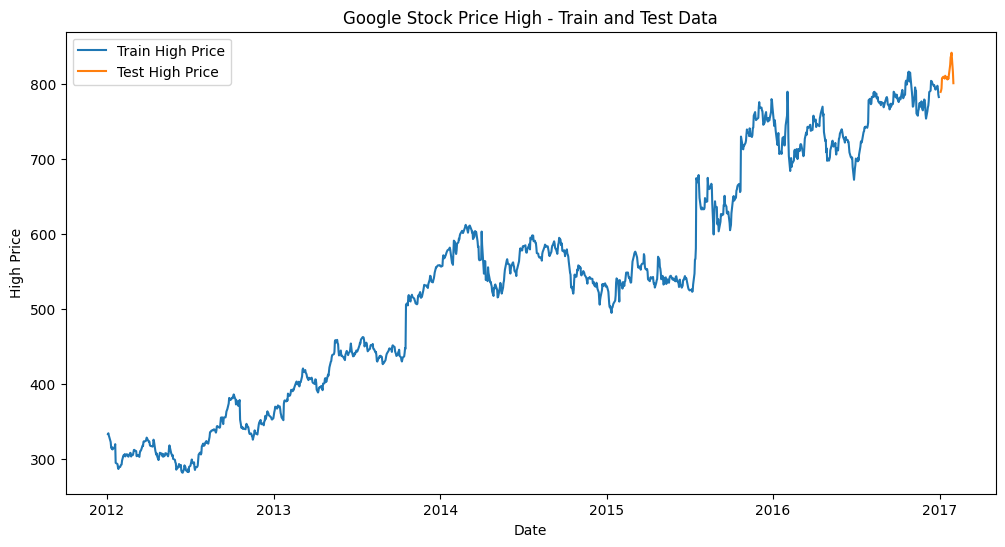

In [24]:
# Hiển thị thông tin cơ bản và vẽ đồ thị tập dữ liệu
plt.figure(figsize=(12, 6))
plt.plot(train_data['High'], label='Train High Price')
plt.plot(test_data['High'], label='Test High Price')
plt.title('Google Stock Price High - Train and Test Data')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

Dữ liệu High của giá cổ phiếu Google trong tập huấn luyện có xu hướng tăng dần, cho thấy đây là một chuỗi có xu hướng (trend). Để xây dựng mô hình ARIMA hoặc SARIMA hiệu quả, ta cần kiểm tra tính dừng của chuỗi và loại bỏ xu hướng (nếu cần) để đưa chuỗi về trạng thái dừng.

<Figure size 1500x1600 with 0 Axes>

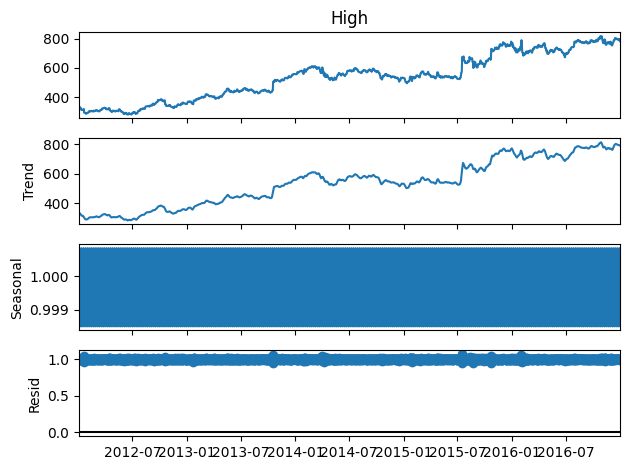

In [25]:
# Xét tính mùa vụ
from statsmodels.tsa.seasonal import seasonal_decompose
plt.figure(figsize=(15,16))
result = seasonal_decompose(train_series, model='multiplicative',extrapolate_trend='freq')
result.plot()
plt.show()

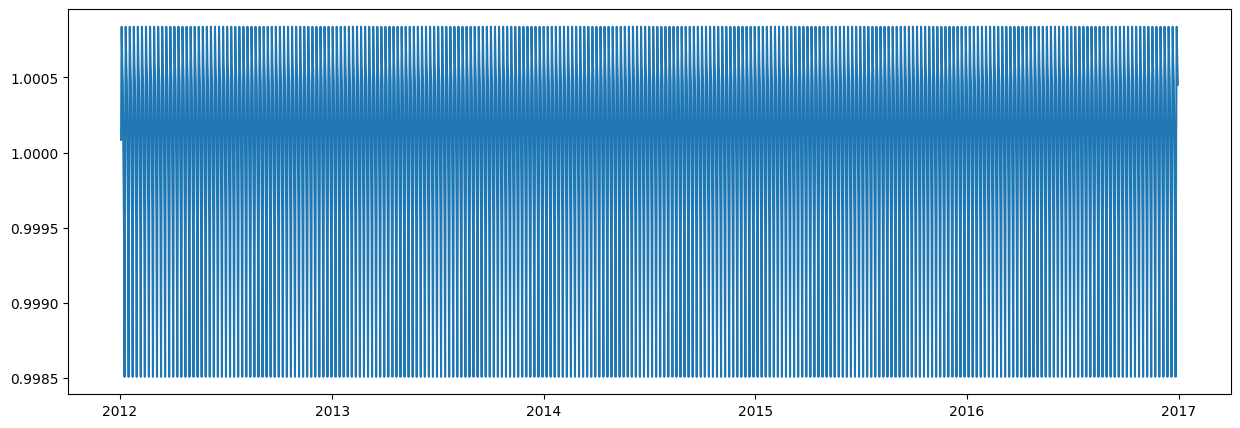

In [ ]:
#  Xét thành phần seasonal
plt.figure(figsize=(15,5))
plt.plot(result.seasonal)

Với biểu đồ seasonal như thế này, có thể kết luận rằng không có tính mùa vụ rõ ràng trong chuỗi thời gian của giá cổ phiếu này.
Mô hình ARIMA cơ bản sẽ phù hợp hơn so với SARIMA, vì không có bằng chứng về chu kỳ lặp lại trong dữ liệu này.

 Tạo model dự báo

Tiếp theo, cần kiểm tra tính dừng của chuỗi bằng kiểm định Augmented Dickey-Fuller (ADF)

In [27]:
# Kiểm tra tính dừng với ADF test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    if (result[1]<0.05): 
        print('Data is stationary')
    else:
        print('Data is not stationary')
# Kiểm tra xem tập data có tính dừng không
adf_test(train_series)

ADF Statistic: -0.6905932212146744
p-value: 0.8491710826846219
Data is not stationary


Dữ liệu chưa có tính dừng, cần thực hiện sai phân

In [28]:
# Thực hiện sai phân lần 1 để tạo tính dừng
diff_series = train_series.diff(1).dropna()
adf_test(diff_series)

ADF Statistic: -18.52830790546519
p-value: 2.1045990240692388e-30
Data is stationary


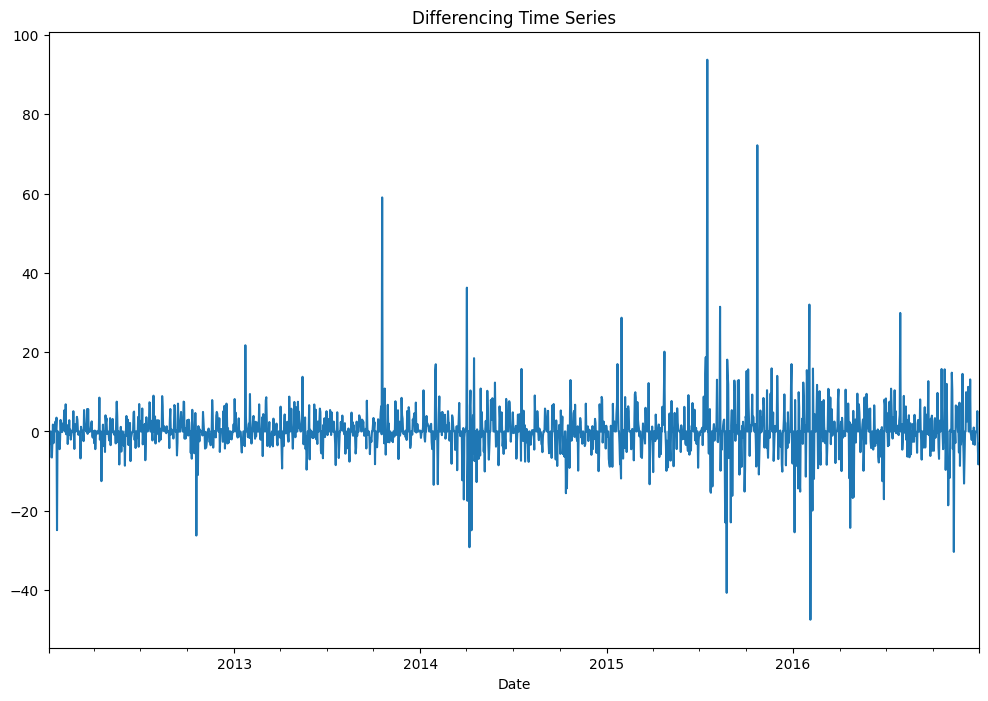

In [29]:
# Vẽ biểu đồ data set đã sai phân
diff_series.plot(figsize=(12, 8))
plt.title('Differencing Time Series')
plt.show()

Sau khi sai phân 1 lần, dữ liệu đã có tính dừng

=> Chọn d = 1, tìm tiếp p và q

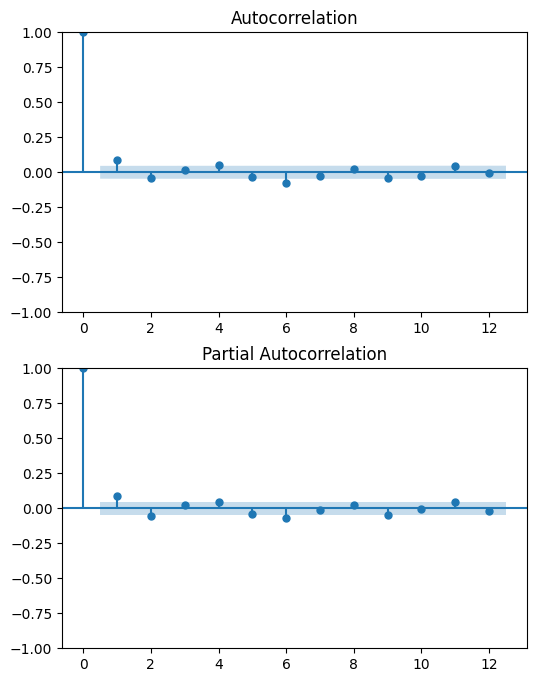

In [30]:
# Vẽ biểu đồ ACF và PACF để tính mức độ tương quan
fig, ax = plt.subplots(2, 1, figsize=(6, 8))
plot_acf(diff_series, ax=ax[0], lags = 12, alpha= 0.05)  
plot_pacf(diff_series, ax=ax[1], lags= 12, alpha =0.05)
plt.show()

- Trong biểu đồ Partial Autocor, có p = 1 vì đây giá trị đầu tiên vượt qua vùng tin cậy
- Trong biểu đồ Autocor, có q = 1 vì đây iá trị đầu tiên vượt qua vùng tin cậy

=> Dựa trên phân tích này, tôi sẽ thử nghiệm với mô hình ARIMA có các giá trị 
(p,d,q)=(1,1,1)

In [31]:
from statsmodels.tsa.arima.model import ARIMA

# Tạo Arima model với (p, d, q) = (1, 1, 1)
arima_model = ARIMA(train_series, order=(1, 1, 1))
arima_fitted = arima_model.fit()

# Fit model
arima_summary = arima_fitted.summary()
arima_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   High   No. Observations:                 1824
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5914.953
Date:                Tue, 12 Nov 2024   AIC                          11835.906
Time:                        13:11:39   BIC                          11852.431
Sample:                    01-03-2012   HQIC                         11842.002
                         - 12-30-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2787      0.179     -1.554      0.120      -0.630       0.073
ma.L1          0.3749      0.176      2.132      0.033       0.030       0.719
sigma2        38.5349      0.303    127.373      0.000      37.942      39.128
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):            161467.31
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               5.81   Skew:                             2.75
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Tiếp theo, sử dụng mô hình này để dự báo giá High trên tập kiểm tra (Test set), sau đó đánh giá kết quả dự báo qua biểu đồ và tính toán độ đo MAE (Mean Absolute Error).

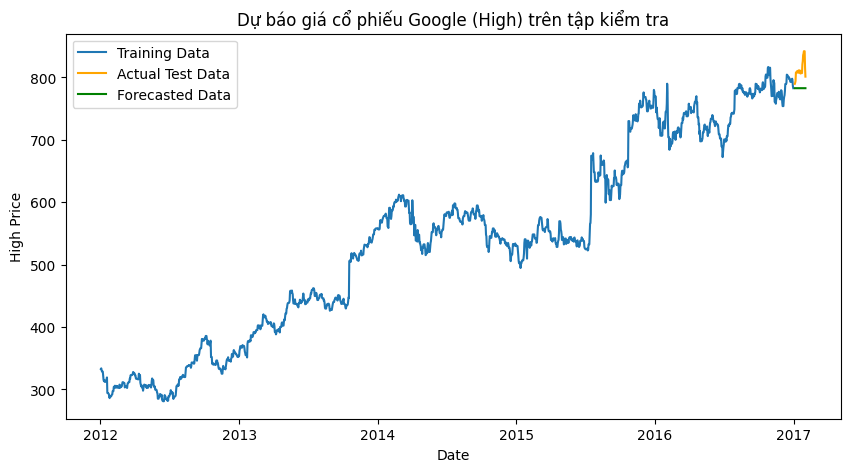

In [32]:
from sklearn.metrics import mean_absolute_error

# Dự báo trên test set
forecast_steps = len(test_series)
forecast = arima_fitted.forecast(steps=forecast_steps)

# Tính sai số tuyệt đối trung bình (MAE) giữa dữ liệu thử nghiệm dự báo và thực tế
mae = mean_absolute_error(test_series, forecast)

# Vẽ các giá trị thực tế và dự báo
plt.figure(figsize=(10, 5))
plt.plot(train_series, label='Training Data')
plt.plot(test_series, label='Actual Test Data', color='orange')
plt.plot(test_series.index, forecast, label='Forecasted Data', color='green')
plt.title('Dự báo giá cổ phiếu Google (High) trên tập kiểm tra')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

Biểu đồ dự báo: Đường màu xanh thể hiện các giá trị dự báo của mô hình ARIMA trên tập kiểm tra, so sánh với giá trị thực tế (màu cam) và dữ liệu huấn luyện (màu xanh dương).

Mô hình ARIMA(1,1,1) có một số khác biệt nhất định giữa giá trị dự báo và thực tế.

In [33]:
# Show mae
mae

30.58237889557196

Độ đo MAE (Mean Absolute Error): 30.58, cho thấy sai số trung bình tuyệt đối giữa giá trị thực tế và dự báo của giá High trên tập kiểm tra.


=> Với MAE này và sự khác biệt giữa giá trị dự đóa và thực tế cần sử dụng các mô hình phức tạp hơn để cải thiện độ chính xác.

### Dùng Auto ARIMA model

In [34]:
# Tạo auto arima
from pmdarima import auto_arima
auto_model = auto_arima(train_series, max_p=12, max_q=12, m=12, d=1,
                           start_P=1, seasonal=False,
                           D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11826.802, Time=0.76 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11849.237, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11837.541, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11836.042, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11850.093, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11836.572, Time=0.29 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11836.277, Time=0.35 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11824.346, Time=0.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11837.102, Time=0.37 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11826.461, Time=0.92 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11826.302, Time=1.34 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=11825.991, Time=0.93 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11835.494, Time=0.56 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11828.298, Time=1.99 sec
 ARIMA(3,1,2)(0,0,0

In [35]:
# Fit model
auto_model.fit(train_series)

ARIMA(order=(3, 1, 2), scoring_args={}, suppress_warnings=True)

In [36]:
# Dự báo trên test set
forecast_auto = pd.DataFrame(auto_model.predict(n_periods= int(test_series.size)))

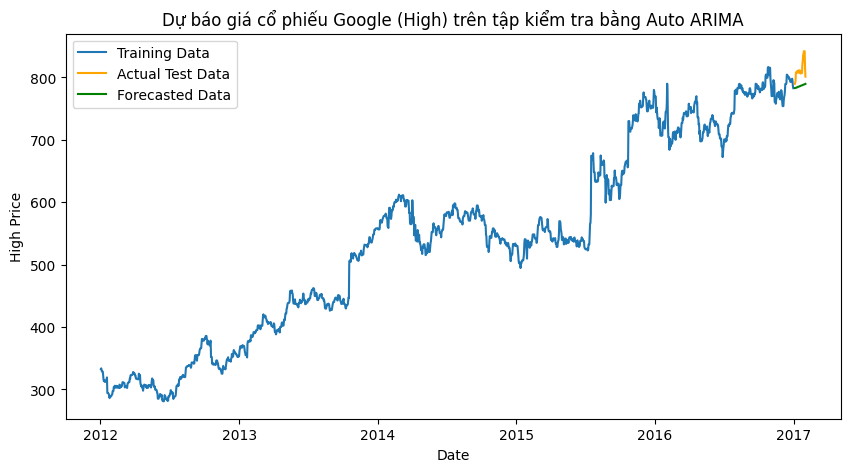

In [37]:
# Tính sai số tuyệt đối trung bình (MAE) giữa dữ liệu thử nghiệm dự báo và thực tế
mae_auto = mean_absolute_error(test_series, forecast_auto)

# Vẽ các giá trị thực tế và dự báo
plt.figure(figsize=(10, 5))
plt.plot(train_series, label='Training Data')
plt.plot(test_series, label='Actual Test Data', color='orange')
plt.plot(test_series.index, forecast_auto, label='Forecasted Data', color='green')
plt.title('Dự báo giá cổ phiếu Google (High) trên tập kiểm tra bằng Auto ARIMA')
plt.xlabel('Date')
plt.ylabel('High Price')
plt.legend()
plt.show()

In [38]:
mae_auto

27.169760125665853

- Chỉ số lỗi MAE của Auto ARIMA : 27.17, thấp hơn so với MAE của mô hình ARIMA(1,1,1), là 30.58

- Biểu đồ dự báo: Auto ARIMA (3,1,2) bám sát giá trị thực tế của tập kiểm tra hơn so với ARIMA (1,1,1), thể hiện qua dự báo trong ngắn hạn (đường màu xanh lá) gần đúng hơn với dữ liệu thực tế (đường màu cam).

=> Tuy nhiên sự trùng khớp chưa cao

### Dùng Random Forest, XGBoost model

In [39]:
# Import libaries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [40]:
# Load the data
train_data = pd.read_csv(r"C:\Users\Dell03.LAPTOP-PTNNLMOI\Desktop\SANG\Machine Learning\Final_K298-20241027T013257Z-001\GK_ML_K298_Nguyen_Dinh_Sang\Google_Stock_Price_Train.csv")
test_data = pd.read_csv(r"C:\Users\Dell03.LAPTOP-PTNNLMOI\Desktop\SANG\Machine Learning\Final_K298-20241027T013257Z-001\GK_ML_K298_Nguyen_Dinh_Sang\Google_Stock_Price_Test.csv")

In [41]:
# Hiển thị tập train
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [42]:
# Hiển thị tập test
test_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


Làm sạch tập train

In [43]:
# Mô tả tập train
train_data.describe()

,Open,High,Low
count,1258.000000,1258.000000,1258.000000
mean,533.709833,537.880223,529.007409
std,151.904442,153.008811,150.552807
min,279.120000,281.210000,277.220000
25%,404.115000,406.765000,401.765000
50%,537.470000,540.750000,532.990000
75%,654.922500,662.587500,644.800000
max,816.680000,816.680000,805.140000


In [44]:
# Loại dữ liệu tập train
train_data.dtypes

Date       object
Open      float64
High      float64
Low       float64
Close      object
Volume     object
dtype: object

Cột Date, Close và Volume sai loại dữ liệu

In [45]:
# Chuyển đổi loại của các feature tập train
train_data['Date'] = pd.to_datetime(train_data['Date'])
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(int)
train_data['Close'] = train_data['Close'].astype(float)
train_data['Volume'] = train_data['Volume'].astype(int)
train_data.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int32
dtype: object

In [46]:
# kiểm tra lỗi tập train
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 54.2 KB


Dữ liệu đã đúng loại và không có lỗi null

In [47]:
# Mô tả tập train sau xử lý
train_data.describe()

,Date,Open,High,Low,Close,Volume
count,1258,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,2014-07-03 20:00:45.786963456,533.709833,537.880223,529.007409,712.669666,3.158107e+06
min,2012-01-03 00:00:00,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,2013-04-05 18:00:00,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,2014-07-05 00:00:00,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,2015-10-01 18:00:00,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,2016-12-30 00:00:00,816.680000,816.680000,805.140000,1216.830000,2.497790e+07
std,NaN,151.904442,153.008811,150.552807,164.752591,2.273726e+06


Làm sạch tập test

In [48]:
# Mô tả tập test
test_data.describe()

,Open,High,Low,Close
count,20.000000,20.000000,20.000000,20.000000
mean,807.526000,811.926500,801.949500,807.904500
std,15.125428,14.381198,13.278607,13.210088
min,778.810000,789.630000,775.800000,786.140000
25%,802.965000,806.735000,797.427500,802.282500
50%,806.995000,808.640000,801.530000,806.110000
75%,809.560000,817.097500,804.477500,810.760000
max,837.810000,841.950000,827.010000,835.670000


Cột Date và Volume sai loại dữ liệu

In [49]:
# Chuyển đổi dữ liệu tập test
test_data['Date'] = pd.to_datetime(test_data['Date'])
test_data['Volume'] = test_data['Volume'].str.replace(',', '').astype(int)
test_data['Volume'] = test_data['Volume'].astype(int)

In [50]:
# kiểm tra lỗi tập test
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   Open    20 non-null     float64       
 2   High    20 non-null     float64       
 3   Low     20 non-null     float64       
 4   Close   20 non-null     float64       
 5   Volume  20 non-null     int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 1012.0 bytes


Dữ liệu đã đúng loại và không có lỗi null

In [51]:
# Mô tả tập test
test_data.describe()

,Date,Open,High,Low,Close,Volume
count,20,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,2017-01-16 15:36:00,807.526000,811.926500,801.949500,807.904500,1.659895e+06
min,2017-01-03 00:00:00,778.810000,789.630000,775.800000,786.140000,9.193000e+05
25%,2017-01-09 18:00:00,802.965000,806.735000,797.427500,802.282500,1.248500e+06
50%,2017-01-17 12:00:00,806.995000,808.640000,801.530000,806.110000,1.418050e+06
75%,2017-01-24 06:00:00,809.560000,817.097500,804.477500,810.760000,1.743400e+06
max,2017-01-31 00:00:00,837.810000,841.950000,827.010000,835.670000,3.246600e+06
std,NaN,15.125428,14.381198,13.278607,13.210088,6.774747e+05


Chuẩn bị dữ liệu cho mô hình


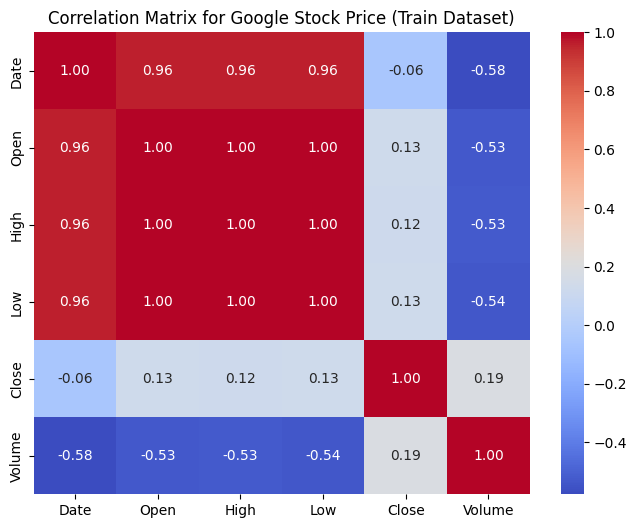

In [52]:
# Bản đồ nhiệt tương quan để hiểu mối quan hệ giữa các feature
plt.figure(figsize=(8, 6))
sns.heatmap(train_data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix for Google Stock Price (Train Dataset)")
plt.show()

Ma trận tương quan cho thấy mối quan hệ rất mạnh giữa các biến Open, Low, và Close với High, đặc biệt là Open và Close. Có thể kết luận rằng các cột này có thể đóng vai trò quan trọng trong việc dự báo giá cao nhất của cổ phiếu. Khối lượng giao dịch (Volume) có mối tương quan thấp hơn, nhưng vẫn có thể là một yếu tố ảnh hưởng trong một số trường hợp.

Chọn các cột Open, Low, Close, và Volume làm các đặc trưng chính để dự báo cột High (giá cổ phiếu cao nhất mỗi ngày), vì chúng có mối quan hệ gần với biến mục tiêu High.

In [53]:
# Tách dữ liệu thành X (đặc trưng) và y (mục tiêu)
X_train = train_data[['Open', 'Low', 'Close', 'Volume']]
y_train = train_data['High']

In [54]:
from skopt import BayesSearchCV

In [55]:
# Danh sách các mô hình và tham số
model_params = [
    {
        'name': 'Random Forest',
        'model': RandomForestRegressor(n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['sqrt', 'log2', None]
        }
    },
    {
        'name': 'XGBoost',
        'model': xgb.XGBRegressor(),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'subsample': [0.8, 1.0],
            'colsample_bytree': [0.8, 1.0]
        }
    }
]

# Danh sách lưu trữ kết quả
results = []

# Vòng lặp qua các mô hình và thực hiện BayesSearchCV
for mp in model_params:
    model_name = mp['name']
    model = mp['model']
    params = mp['params']
    
    # Thời gian bắt đầu
    start_time = time.time()
    
    # BayesSearchCV
    Bayes_search = BayesSearchCV(model, params, cv=5, scoring='neg_mean_absolute_error')
    Bayes_search.fit(X_train, y_train)
    
    # Thời gian kết thúc
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    # Lưu kết quả
    results.append({
        'Model': model_name,
        'Best Parameters': Bayes_search.best_params_,
        'Best Score (MAE)': -Bayes_search.best_score_,  # Đổi dấu để lấy MAE dương
        'Time': elapsed_time
    })

# Chuyển kết quả thành DataFrame
df_results = pd.DataFrame(results)
print(df_results)

           Model                                    Best Parameters  \
0  Random Forest  {'max_depth': None, 'max_features': None, 'min...   
1        XGBoost  {'colsample_bytree': 1.0, 'learning_rate': 0.2...   

   Best Score (MAE)        Time  
0         17.703924  132.351525  
1         17.985407   81.399687  


Kết luận: 

=> Có các chỉ số:
- Random Forest, (MAE): 17.703924
- XGBoost, (MAE): 17.985407
- Auto ARIMA, (MAE): 27.169760
- ARIMA (MAE): 30.58237889557196

=> Random Forest và XGBoost đều có giá trị MAE thấp hơn đáng kể so với ARIMA và Auto ARIMA. Điều này cho thấy hai mô hình này có khả năng dự báo tốt hơn ARIMA trong bối cảnh bài toán này.
ARIMA có thể không phù hợp bằng Random Forest và XGBoost cho tập dữ liệu hiện tại.

=> Nếu tối ưu hóa thời gian và độ chính xác, XGBoost có thể được chọn vì có độ lỗi MAE tương đương nhưng time nhanh hơn (cần so sánh thêm các chỉ số khác)

### Sử dụng Deeplearning (LSTM)

In [184]:
# Sử dụng lại tập train, test đã làm sạch ở 2.3

train_data = train_data[['Date', 'High']]
test_data = test_data[['Date', 'High']]

train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   High    1258 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    20 non-null     datetime64[ns]
 1   High    20 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 452.0 bytes


In [185]:
from sklearn.preprocessing import MinMaxScaler
# Tách riêng cột 'High' để scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data[['High']])
test_scaled = scaler.transform(test_data[['High']])

# Giữ lại cột 'Date' để sử dụng cho mục đích trực quan hóa sau này
train_dates = train_data['Date']
test_dates = test_data['Date']


In [186]:
# Tạo hàm tạo chuỗi cho LTSM
def create_sequences(data, seq_length=12):
    x, y = [], []
    for i in range(seq_length, len(data)):
        x.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(x), np.array(y)

In [ ]:
# Tạo chuỗi
seq_length = 12  # Sử dụng 12 điểm dữ liệu trước đó để dự báo dự báo điểm tiếp theo
x_train, y_train = create_sequences(np.array(train_scaled), seq_length)
x_test, y_test = create_sequences(np.array(test_scaled), seq_length)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1246, 12), (1246,), (8, 12), (8,))

In [ ]:
# Reshape data 
x_train_reshaped = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test_reshaped = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

x_train_reshaped.shape, y_train.shape, x_test_reshaped.shape, y_test.shape

((1246, 12, 1), (1246,), (8, 12, 1), (8,))

Dữ liệu đã được định dạng lại thành công cho mô hình LSTM:

Tập train có 1246 chuỗi với độ dài 12 ngày.
Tập test hiện chỉ có 8 chuỗi.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Tạo LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train_reshaped.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)  # Output layer for single value prediction
])

# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model
history = model.fit(x_train_reshaped, y_train, epochs=10, batch_size=32, verbose=1)

# Hiển thị thông tin model
model.summary()

Epoch 1/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.2292
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0502
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0498
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0446
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0474
Epoch 6/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0456
Epoch 7/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0431
Epoch 8/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0431
Epoch 9/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0427
Epoch 10/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0412


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 12, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_23 (LSTM)                  │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152,555 (595.92 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 101,704 (397.29 KB)

In [ ]:
# Dự báo y_pred
y_pred = model.predict(x_test_reshaped)

# Inversing dữ liệu y_pred
y_pred_actual = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Inversing dữ liệu y_test
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Tính toán MAE
mae = mean_absolute_error(y_test_actual, y_pred_actual)
print(f"Mean Absolute Error: {mae}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step
Mean Absolute Error: 13.182351379394532


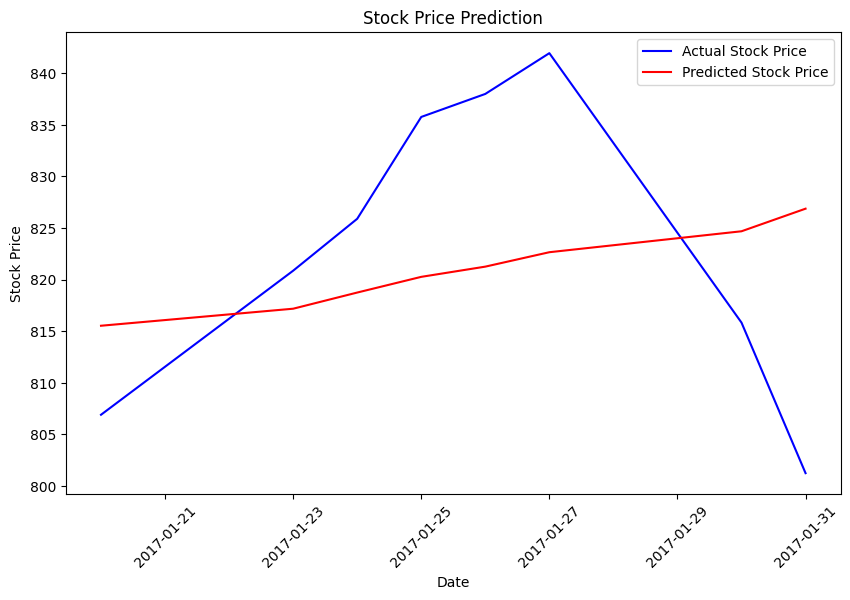

In [ ]:
# Hiển thị dữ liệu dự báo và thực tế
plt.figure(figsize=(10, 6))
plt.plot(test_dates[-len(y_test_actual):], y_test_actual, color='blue', label='Actual Stock Price')
plt.plot(test_dates[-len(y_pred_actual):], y_pred_actual, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.xticks(rotation=45)
plt.legend()
plt.show()

Dự liệu dự báo khá tiệm cận với dữ liệu thực tế

### Kết luận: 
Kết quả của các mô hình:
- LSTM: MAE = 13.182
- Random Forest: MAE = 17.704
- XGBoost: MAE = 17.985
- Auto ARIMA: MAE = 27.170
- ARIMA: 30.582

=> Mô hình LSTM vượt trội so với các mô hình khác trong việc dự báo giá trị High của chuỗi thời gian. Điều này chứng tỏ sức mạnh của các mô hình học sâu như LSTM khi xử lý dữ liệu thời gian có mối quan hệ phi tuyến tính phức tạp.

=> Random Forest và XGBoost có hiệu suất gần như tương tự nhau, nhưng không bằng LSTM do thiếu khả năng xử lý thứ tự thời gian tự nhiên. ARIMA có hiệu suất kém nhất, có thể do chuỗi thời gian của bạn chứa nhiều yếu tố phi tuyến tính mà ARIMA khó có thể học được.